# Oversampling on class regrouping

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm
from sklearn.pipeline import make_pipeline

import warnings

# suppress warning from MLP
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FutureWarning)


Importing datasets manually

In [10]:
df_white = pd.read_csv('../winequality-white.csv', sep=';')

I add a color column to the datasets

In [11]:
df_white

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


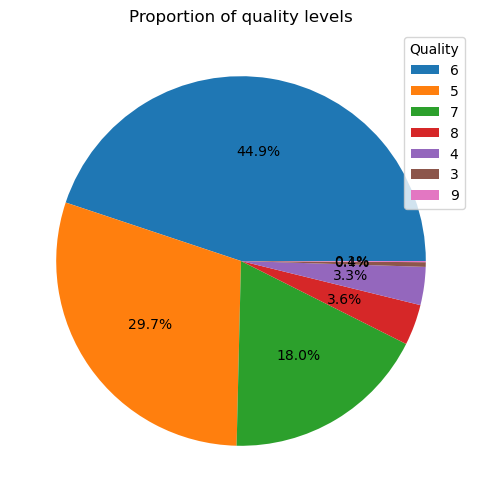

In [12]:
y = df_white['quality']
count = y.value_counts()
plt.figure(figsize=(10, 6))
plt.pie(count, labels=None, autopct='%1.1f%%')
plt.title('Proportion of quality levels')
plt.legend(labels=count.index, title="Quality", loc="best")
plt.show()

## Regrouping the target classes

3--4 $\rightarrow$ 1;   
5 $\rightarrow$ 2;  
6 $\rightarrow$ 3;  
7--8--9 $\rightarrow$ 4;    



In [13]:
df_white['quality'] = df_white['quality'].replace({
    3: 1, 4: 1,
    5: 2,
    6: 3,
    7: 4, 8: 4, 9: 4
})


In [14]:
# Use smote to balance the dataset
X = df_white.drop('quality', axis=1)
y = df_white['quality']
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
X_resampled = pd.DataFrame(X_resampled, columns=X.columns)
y_resampled = pd.Series(y_resampled, name='quality')

df_white = pd.concat([X_resampled, y_resampled], axis=1)
df_white['quality'].value_counts()


quality
3    2198
2    2198
4    2198
1    2198
Name: count, dtype: int64

## Expolaratory Data analysis

We start with a pie chart to look at the proportion of quality levels

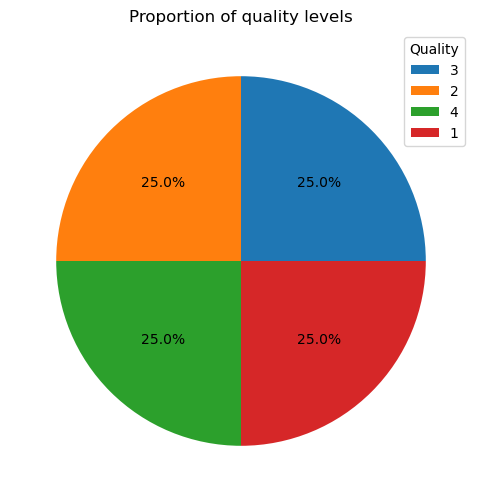

In [15]:
y = df_white['quality']
count = y.value_counts()
plt.figure(figsize=(10, 6))
plt.pie(count, labels=None, autopct='%1.1f%%')
plt.title('Proportion of quality levels')
plt.legend(labels=count.index, title="Quality", loc="best")
plt.show()

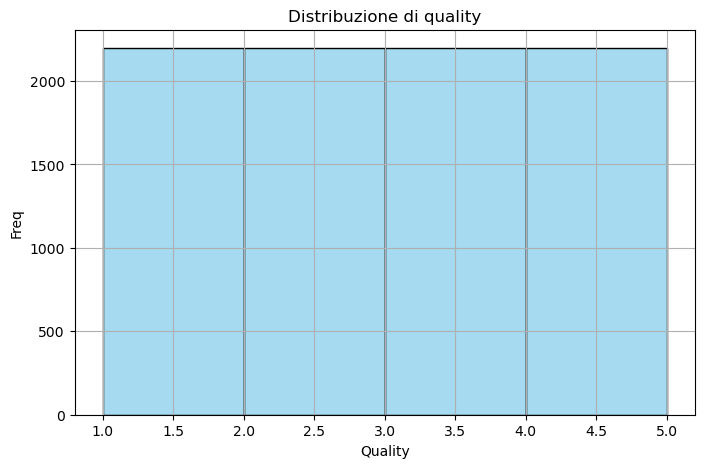

In [16]:
plt.figure(figsize=(8, 5))
sns.histplot(df_white['quality'], bins=range(df_white['quality'].min(), df_white['quality'].max()+2), color='skyblue')
plt.title("Distribuzione di quality")
plt.xlabel("Quality")
plt.ylabel("Freq")
plt.grid(True)
plt.show()

It is a good distribution, thus i'll try first without oversampling

In [17]:
X = df_white.drop(columns='quality')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42, shuffle= True)

X_train

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
6906,8.663543,0.269356,0.335577,2.831900,0.033493,5.000000,33.584449,0.992193,2.960134,0.326756,10.885788
3399,5.600000,0.320000,0.330000,7.400000,0.037000,25.000000,95.000000,0.992680,3.250000,0.490000,11.100000
2485,8.000000,0.280000,0.320000,7.600000,0.045000,61.000000,204.000000,0.995430,3.100000,0.550000,10.100000
694,7.600000,0.290000,0.580000,17.500000,0.041000,51.000000,225.000000,0.999700,3.160000,0.660000,9.500000
4119,6.500000,0.400000,0.310000,3.500000,0.046000,22.000000,147.000000,0.990240,3.150000,0.310000,12.000000
...,...,...,...,...,...,...,...,...,...,...,...
5734,6.700000,0.315564,0.309032,9.832263,0.040218,9.951616,175.072575,0.995293,3.452742,0.545887,11.351616
5191,6.410833,0.387591,0.245783,6.634965,0.067843,9.096376,117.096376,0.994266,3.150964,0.355783,10.161449
5390,9.418226,0.328364,0.683739,10.120560,0.093776,35.397199,225.401867,0.997821,3.021823,0.492289,9.819160
860,8.100000,0.270000,0.350000,1.700000,0.030000,38.000000,103.000000,0.992550,3.220000,0.630000,10.400000


# EXPERIMENTS
We start by looking at the best performing models w/o optmization.
First we load the models

In [18]:
models = {
    'SVM': SVC(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'MLP': MLPClassifier(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier()
}

We then scale the sets

In [19]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

And now we train all the models to select the best permorming ones.

In [20]:
results = {}

for name, model in models.items():
    if name == 'Decision Tree':

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        results[name] = acc
    else:

        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)

        acc = accuracy_score(y_test, y_pred)
        results[name] = acc


# sort the map results by accuracy
results = dict(sorted(results.items(), key=lambda item: item[1], reverse=True))
results

{'Decision Tree': 0.7288231949971575,
 'MLP': 0.7060830017055145,
 'SVM': 0.6526435474701535,
 'Logistic Regression': 0.5252984650369528}

In [21]:
# code to take only the first 2 models
top_models = list(results.keys()) #[:2]

In [22]:
param_grids = {
    'MLP': {
        'mlpclassifier__hidden_layer_sizes': [(50,), (100,), (100, 50)],
        'mlpclassifier__alpha': [0.0001, 0.001]
    },
    'SVM': {
        'svc__C': [0.1, 1, 10],
        'svc__kernel': ['linear', 'rbf']
    },
    'Logistic Regression': {
        'logisticregression__C': [0.1, 1, 10],
        'logisticregression__penalty': ['l2', 'l1'],
        'logisticregression__solver': ['liblinear']
    },
    'Decision Tree': {
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    }
}


In [23]:

# i wanto to pop the key that there aren't in the top_models
for model in list(param_grids.keys()):
    if model not in top_models:
        param_grids.pop(model)

param_grids

{'MLP': {'mlpclassifier__hidden_layer_sizes': [(50,), (100,), (100, 50)],
  'mlpclassifier__alpha': [0.0001, 0.001]},
 'SVM': {'svc__C': [0.1, 1, 10], 'svc__kernel': ['linear', 'rbf']},
 'Logistic Regression': {'logisticregression__C': [0.1, 1, 10],
  'logisticregression__penalty': ['l2', 'l1'],
  'logisticregression__solver': ['liblinear']},
 'Decision Tree': {'max_depth': [None, 10, 20],
  'min_samples_split': [2, 5, 10]}}

Here we train using gridsearch (and also RFE for decision trees)

In [24]:
models = {
    'MLP': make_pipeline(StandardScaler(), MLPClassifier(max_iter=1000)),
    'SVM': make_pipeline(StandardScaler(), SVC()),
    'Logistic Regression': make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000)),
    'Decision Tree': DecisionTreeClassifier()
}

# Grid Search con tqdm
best_models = {}
for name in tqdm(param_grids.keys(), desc="Grid search", total=len(param_grids)):

    print(f"\nEseguo GridSearch per: {name}")
    model = models[name]
    grid = GridSearchCV(model, param_grids[name], cv=5, n_jobs=-1, verbose=0)
    grid.fit(X, y)
    best_models[name] = grid.best_params_
    print(f"Migliori parametri per {name}: {grid.best_params_}")
    print(f"Score: {grid.best_score_:.4f}")

best_models


Grid search:   0%|          | 0/4 [00:00<?, ?it/s]


Eseguo GridSearch per: MLP


Grid search:  25%|██▌       | 1/4 [01:11<03:33, 71.25s/it]

Migliori parametri per MLP: {'mlpclassifier__alpha': 0.0001, 'mlpclassifier__hidden_layer_sizes': (100, 50)}
Score: 0.7085

Eseguo GridSearch per: SVM


Grid search:  50%|█████     | 2/4 [01:21<01:10, 35.38s/it]

Migliori parametri per SVM: {'svc__C': 10, 'svc__kernel': 'rbf'}
Score: 0.6777

Eseguo GridSearch per: Logistic Regression


Grid search:  75%|███████▌  | 3/4 [01:22<00:19, 19.57s/it]

Migliori parametri per Logistic Regression: {'logisticregression__C': 0.1, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}
Score: 0.5066

Eseguo GridSearch per: Decision Tree


Grid search: 100%|██████████| 4/4 [01:22<00:00, 20.71s/it]

Migliori parametri per Decision Tree: {'max_depth': 20, 'min_samples_split': 2}
Score: 0.6518


{'MLP': {'mlpclassifier__alpha': 0.0001,
  'mlpclassifier__hidden_layer_sizes': (100, 50)},
 'SVM': {'svc__C': 10, 'svc__kernel': 'rbf'},
 'Logistic Regression': {'logisticregression__C': 0.1,
  'logisticregression__penalty': 'l1',
  'logisticregression__solver': 'liblinear'},
 'Decision Tree': {'max_depth': 20, 'min_samples_split': 2}}

In [25]:
# instancing the model with the best parameters
accuracies = {}

for model_name in top_models:
    match model_name:
        case 'Decision Tree':
            tuned_model = DecisionTreeClassifier(**best_models[model_name])
        case 'MLP':
            tuned_model = make_pipeline(StandardScaler(), MLPClassifier(max_iter=1000))
            tuned_model.set_params(**best_models[model_name])
        case 'SVM':
            tuned_model = make_pipeline(StandardScaler(), SVC())
            tuned_model.set_params(**best_models[model_name])
        case 'Logistic Regression':
            tuned_model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
            tuned_model.set_params(**best_models[model_name])
    
    tuned_model.fit(X_train, y_train)
    y_pred = tuned_model.predict(X_test)
    accuracies[model_name] = accuracy_score(y_test, y_pred)

    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_test, y_pred))

# Sort accuracies
accuracies = dict(sorted(accuracies.items(), key=lambda item: item[1], reverse=True))
print("\nAccuracies of the tuned models:")
for model_name, accuracy in accuracies.items():
    print(f"{model_name}: {accuracy:.4f}")


Classification Report for Decision Tree:
              precision    recall  f1-score   support

           1       0.86      0.86      0.86       469
           2       0.63      0.65      0.64       429
           3       0.60      0.60      0.60       439
           4       0.78      0.76      0.77       422

    accuracy                           0.72      1759
   macro avg       0.72      0.72      0.72      1759
weighted avg       0.72      0.72      0.72      1759


Classification Report for MLP:
              precision    recall  f1-score   support

           1       0.92      0.94      0.93       469
           2       0.74      0.73      0.74       429
           3       0.65      0.58      0.61       439
           4       0.76      0.84      0.80       422

    accuracy                           0.78      1759
   macro avg       0.77      0.78      0.77      1759
weighted avg       0.77      0.78      0.77      1759


Classification Report for SVM:
              precision 

In [26]:
# Pipeline modello
pipeline = make_pipeline(StandardScaler(), MLPClassifier(max_iter=500, random_state=42))


local_param_grid = {
    'mlpclassifier__solver': ['adam'],
    'mlpclassifier__learning_rate_init': [0.0005, 0.001, 0.005],
    'mlpclassifier__learning_rate': ['constant', 'adaptive'],
    'mlpclassifier__hidden_layer_sizes': [(128, 64), (100, 50), (128, 64, 32)],
    'mlpclassifier__alpha': np.logspace(-5, -2, 5),
    'mlpclassifier__activation': ['relu', 'tanh']
}

# Random search
search = GridSearchCV(pipeline, local_param_grid, cv=3, n_jobs=-1, verbose=10)

# Fit
search.fit(X, y)

# Risultati
print(f"\nMigliori parametri trovati: {search.best_params_}")
print(f"Score medio CV: {search.best_score_:.4f}")

Fitting 3 folds for each of 180 candidates, totalling 540 fits
[CV 1/3; 1/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam
[CV 2/3; 1/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam
[CV 1/3; 2/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam
[CV 2/3; 2/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 2/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.748 total time=  15.7s
[CV 1/3; 5/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam
[CV 3/3; 1/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.738 total time=  15.9s
[CV 2/3; 5/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam
[

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 1/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.675 total time=  16.0s
[CV 3/3; 5/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam
[CV 1/3; 6/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam
[CV 2/3; 1/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.690 total time=  16.1s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 4/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.675 total time=  16.8s
[CV 2/3; 7/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 4/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.690 total time=  16.4s
[CV 3/3; 7/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam
[CV 3/3; 6/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.727 total time=   4.4s
[CV 1/3; 8/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 4/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.738 total time=  16.4s
[CV 2/3; 8/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam
[CV 2/3; 5/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.695 total time=  15.9s
[CV 3/3; 8/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 5/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.692 total time=  16.5s
[CV 1/3; 9/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam
[CV 3/3; 5/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.748 total time=  16.5s
[CV 2/3; 9/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 7/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.656 total time=  12.8s
[CV 3/3; 9/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 7/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.671 total time=  12.8s
[CV 1/3; 10/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam
[CV 2/3; 9/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.695 total time=   3.6s
[CV 2/3; 10/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=ad

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 9/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.669 total time=   5.3s
[CV 3/3; 11/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam
[CV 2/3; 8/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.686 total time=  11.3s
[CV 1/3; 12/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 8/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.716 total time=  12.7s
[CV 2/3; 12/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 10/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.656 total time=  12.6s
[CV 3/3; 12/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam
[CV 2/3; 12/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.695 total time=   3.4s
[CV 1/3; 13/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solv

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 10/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.726 total time=  12.6s
[CV 2/3; 14/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam
[CV 1/3; 11/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.667 total time=  12.5s
[CV 3/3; 14/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__s

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 15/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.683 total time=   3.0s
[CV 3/3; 15/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam
[CV 2/3; 15/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.686 total time=   3.9s
[CV 1/3; 16/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclass

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 13/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.733 total time=  21.6s
[CV 3/3; 18/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam
[CV 2/3; 17/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.693 total time=  10.7s
[CV 1/3; 19/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 16/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.733 total time=  21.4s
[CV 3/3; 21/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam
[CV 2/3; 21/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.694 total time=   4.7s
[CV 1/3; 22/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 19/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.680 total time=  17.5s
[CV 3/3; 22/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 19/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.688 total time=  17.8s
[CV 1/3; 23/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam
[CV 1/3; 20/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.686 total time=  17.1s
[CV 2/3; 23/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, m

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 20/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.742 total time=  15.8s
[CV 1/3; 24/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam
[CV 2/3; 20/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.691 total time=  17.6s
[CV 2/3; 24/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, ml

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 22/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.680 total time=  17.8s
[CV 3/3; 25/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 22/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.688 total time=  18.1s
[CV 1/3; 26/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam
[CV 3/3; 23/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.742 total time=  15.9s
[CV 2/3; 26/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, m

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 22/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.733 total time=  17.9s
[CV 3/3; 26/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam
[CV 1/3; 23/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.686 total time=  17.2s
[CV 1/3; 27/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, m

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 25/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.660 total time=  13.7s
[CV 1/3; 28/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam
[CV 2/3; 27/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.693 total time=   3.8s
[CV 2/3; 28/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 25/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.676 total time=  13.5s
[CV 3/3; 28/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam
[CV 3/3; 27/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.735 total time=   5.1s
[CV 1/3; 29/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 25/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.709 total time=  13.4s
[CV 2/3; 29/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam
[CV 1/3; 26/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.677 total time=  12.6s
[CV 3/3; 29/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, m

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 26/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.718 total time=  13.3s
[CV 2/3; 30/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam
[CV 1/3; 30/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.683 total time=   2.9s
[CV 3/3; 30/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, ml

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 28/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.676 total time=  13.7s
[CV 2/3; 31/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam
[CV 1/3; 28/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.660 total time=  13.9s
[CV 3/3; 31/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=c

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 28/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.709 total time=  13.8s
[CV 3/3; 32/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam
[CV 2/3; 29/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.679 total time=  12.3s
[CV 1/3; 33/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=con

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 29/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.718 total time=  14.2s
[CV 3/3; 33/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam
[CV 2/3; 33/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.690 total time=   3.7s
[CV 1/3; 34/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 37/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.678 total time=  18.2s
[CV 3/3; 40/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 37/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.697 total time=  18.2s
[CV 1/3; 41/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 37/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.737 total time=  18.0s
[CV 2/3; 41/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 38/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.696 total time=  18.3s
[CV 3/3; 41/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 38/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.686 total time=  18.4s
[CV 1/3; 42/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam
[CV 3/3; 38/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.745 total time=  17.5s
[CV 2/3; 42/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 40/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.678 total time=  18.3s
[CV 2/3; 43/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam
[CV 3/3; 42/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.749 total time=   5.1s
[CV 3/3; 43/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=consta

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 40/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.697 total time=  18.4s
[CV 1/3; 44/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 40/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.737 total time=  18.2s
[CV 2/3; 44/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 41/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.696 total time=  18.6s
[CV 3/3; 44/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 41/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.686 total time=  18.7s
[CV 1/3; 45/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam
[CV 3/3; 41/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.745 total time=  17.9s
[CV 2/3; 45/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 43/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.666 total time=  14.0s
[CV 1/3; 46/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam
[CV 2/3; 45/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.685 total time=   4.9s
[CV 2/3; 46/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adapti

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 43/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.677 total time=  14.6s
[CV 1/3; 47/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam
[CV 1/3; 44/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.663 total time=  12.9s
[CV 2/3; 47/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptiv

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 43/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.718 total time=  14.5s
[CV 3/3; 47/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 44/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.682 total time=  14.4s
[CV 1/3; 48/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 44/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.717 total time=  14.3s
[CV 2/3; 48/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam
[CV 1/3; 48/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.677 total time=   3.1s
[CV 3/3; 48/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 46/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.666 total time=  14.3s
[CV 1/3; 49/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam
[CV 3/3; 48/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.735 total time=   3.4s
[CV 2/3; 49/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rat

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 46/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.677 total time=  14.2s
[CV 1/3; 50/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam
[CV 1/3; 47/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.663 total time=  12.5s
[CV 2/3; 50/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 46/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.718 total time=  14.2s
[CV 3/3; 50/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 47/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.682 total time=  14.2s
[CV 1/3; 51/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam
[CV 3/3; 47/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.717 total time=  13.8s
[CV 2/3; 51/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 55/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.672 total time=  18.8s
[CV 3/3; 58/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 55/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.690 total time=  18.9s
[CV 1/3; 59/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam
[CV 1/3; 56/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.676 total time=  17.8s
[CV 2/3; 59/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, m

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 55/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.731 total time=  18.4s
[CV 3/3; 59/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam
[CV 2/3; 56/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.697 total time=  18.1s
[CV 1/3; 60/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, m

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 58/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.672 total time=  19.4s
[CV 3/3; 61/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 58/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.690 total time=  19.3s
[CV 1/3; 62/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam
[CV 3/3; 59/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.743 total time=  17.0s
[CV 2/3; 62/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, m

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 58/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.731 total time=  19.2s
[CV 3/3; 62/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam
[CV 1/3; 59/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.676 total time=  18.5s
[CV 1/3; 63/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, m

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 61/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.653 total time=  14.4s
[CV 3/3; 63/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam
[CV 1/3; 63/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.671 total time=   4.3s
[CV 1/3; 64/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, m

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 61/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.715 total time=  14.4s
[CV 2/3; 65/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 62/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.670 total time=  14.2s
[CV 3/3; 65/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 62/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.684 total time=  14.3s
[CV 1/3; 66/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 62/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.722 total time=  14.4s
[CV 2/3; 66/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam
[CV 1/3; 66/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.671 total time=   4.5s
[CV 3/3; 66/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, ml

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 64/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.653 total time=  14.9s
[CV 2/3; 67/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 64/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.681 total time=  14.8s
[CV 3/3; 67/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 66/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.737 total time=   4.8s
[CV 3/3; 64/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.715 total time=  14.7s
[CV 1/3; 68/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam
[CV 2/3; 68/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=con

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 65/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.670 total time=  15.1s
[CV 3/3; 68/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 65/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.684 total time=  15.2s
[CV 1/3; 69/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 65/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.722 total time=  15.0s
[CV 2/3; 69/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam
[CV 1/3; 69/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.687 total time=   5.2s
[CV 3/3; 69/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 67/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.738 total time=  25.3s
[CV 2/3; 72/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam
[CV 1/3; 72/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.687 total time=   5.8s
[CV 3/3; 72/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 70/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.738 total time=  29.0s
[CV 2/3; 75/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam
[CV 1/3; 75/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.673 total time=   7.7s
[CV 3/3; 75/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclas

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 73/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.677 total time=  26.9s
[CV 3/3; 76/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 73/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.692 total time=  26.9s
[CV 1/3; 77/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 73/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.735 total time=  26.9s
[CV 2/3; 77/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 74/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.700 total time=  27.2s
[CV 3/3; 77/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 74/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.693 total time=  27.0s
[CV 1/3; 78/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam
[CV 3/3; 74/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.736 total time=  24.4s
[CV 2/3; 78/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam
[C

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 76/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.677 total time=  25.4s
[CV 3/3; 79/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 76/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.692 total time=  25.4s
[CV 1/3; 80/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 76/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.735 total time=  25.0s
[CV 2/3; 80/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam
[CV 3/3; 77/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.736 total time=  22.5s
[CV 3/3; 80/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 77/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.700 total time=  25.2s
[CV 1/3; 81/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 77/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.693 total time=  25.1s
[CV 2/3; 81/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 79/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.654 total time=  19.3s
[CV 3/3; 81/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam
[CV 1/3; 81/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.661 total time=   5.6s
[CV 1/3; 82/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 79/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.672 total time=  19.1s
[CV 1/3; 83/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 79/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.712 total time=  18.9s
[CV 2/3; 83/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam
[CV 1/3; 80/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.677 total time=  18.1s
[CV 3/3; 83/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 80/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.692 total time=  19.3s
[CV 1/3; 84/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam
[CV 3/3; 80/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.716 total time=  19.1s
[CV 2/3; 84/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam
[C

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 82/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.654 total time=  18.7s
[CV 1/3; 85/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam
[CV 2/3; 84/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.686 total time=   6.6s
[CV 2/3; 85/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__sol

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 82/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.672 total time=  18.6s
[CV 3/3; 85/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 82/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.712 total time=  18.8s
[CV 1/3; 86/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam
[CV 3/3; 84/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.718 total time=   4.8s
[CV 2/3; 86/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solve

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 83/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.692 total time=  18.6s
[CV 1/3; 87/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 83/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.716 total time=  19.3s
[CV 2/3; 87/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam
[CV 1/3; 87/180] END mlpclassifier__activation=relu, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.678 total time=   5.7s
[CV 3/3; 87/180] START mlpclassifier__activation=relu, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__so

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 91/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.685 total time=  26.9s
[CV 2/3; 94/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 91/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.683 total time=  26.3s
[CV 3/3; 94/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 91/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.725 total time=  26.6s
[CV 1/3; 95/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam
[CV 3/3; 93/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.722 total time=   9.4s
[CV 2/3; 95/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=ad

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 92/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.697 total time=  27.1s
[CV 3/3; 95/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 92/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.692 total time=  27.0s
[CV 1/3; 96/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 92/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.740 total time=  26.7s
[CV 2/3; 96/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam
[CV 1/3; 96/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.673 total time=   8.7s
[CV 3/3; 96/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=ada

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 94/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.685 total time=  26.3s
[CV 2/3; 97/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam
[CV 3/3; 96/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.722 total time=   8.8s
[CV 3/3; 97/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 94/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.725 total time=  26.1s
[CV 1/3; 98/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam
[CV 2/3; 94/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.683 total time=  26.6s
[CV 2/3; 98/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=a

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 95/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.697 total time=  26.2s
[CV 3/3; 98/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 95/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.692 total time=  26.2s
[CV 1/3; 99/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 95/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.740 total time=  26.0s
[CV 2/3; 99/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 97/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.684 total time=  19.4s
[CV 3/3; 99/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam
[CV 1/3; 99/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.675 total time=   8.8s
[CV 1/3; 100/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 97/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.680 total time=  19.6s
[CV 3/3; 100/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam
[CV 3/3; 99/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.714 total time=   8.8s
[CV 1/3; 101/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 98/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.687 total time=  20.4s
[CV 3/3; 101/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam
[CV 1/3; 98/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.676 total time=  20.5s
[CV 1/3; 102/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=a

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 98/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.727 total time=  20.2s
[CV 2/3; 102/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam
[CV 1/3; 102/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.675 total time=   9.3s
[CV 3/3; 102/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 100/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.684 total time=  21.7s
[CV 2/3; 103/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 100/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.680 total time=  21.4s
[CV 3/3; 103/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 100/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.719 total time=  21.3s
[CV 1/3; 104/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 101/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.676 total time=  20.9s
[CV 2/3; 101/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.687 total time=  20.8s
[CV 2/3; 104/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam
[CV 3/3; 104/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 101/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.727 total time=  20.9s
[CV 2/3; 105/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam
[CV 1/3; 105/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.647 total time=   7.4s
[CV 3/3; 105/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassi

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 103/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.670 total time=  33.3s
[CV 1/3; 107/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam
[CV 2/3; 104/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.698 total time=  27.0s
[CV 3/3; 104/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpcla

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 103/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.680 total time=  33.9s
[CV 1/3; 108/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 103/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.740 total time=  33.6s
[CV 2/3; 108/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam
[CV 2/3; 108/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.683 total time=   6.5s
[CV 3/3; 108/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpc

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 106/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.670 total time=  35.2s
[CV 3/3; 109/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 106/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.680 total time=  34.0s
[CV 1/3; 110/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam
[CV 2/3; 107/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.698 total time=  26.5s
[CV 2/3; 110/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learni

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 106/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=1e-05, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.740 total time=  33.5s
[CV 2/3; 111/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam
[CV 1/3; 111/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.677 total time=   8.5s
[CV 3/3; 111/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassi

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 109/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.685 total time=  27.9s
[CV 1/3; 112/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam
[CV 2/3; 111/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.688 total time=   7.8s
[CV 2/3; 112/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adapti

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 109/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.683 total time=  27.2s
[CV 3/3; 112/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 109/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.725 total time=  27.1s
[CV 1/3; 113/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam
[CV 3/3; 111/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.706 total time=   9.3s
[CV 2/3; 113/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptiv

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 110/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.698 total time=  26.8s
[CV 3/3; 113/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 110/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.691 total time=  26.2s
[CV 1/3; 114/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 110/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.740 total time=  26.8s
[CV 2/3; 114/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam
[CV 1/3; 114/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.677 total time=   8.2s
[CV 3/3; 114/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 112/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.685 total time=  26.4s
[CV 2/3; 115/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 112/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.683 total time=  26.0s
[CV 3/3; 115/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam
[CV 3/3; 114/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.706 total time=   8.9s
[CV 1/3; 116/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=consta

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 112/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.725 total time=  25.9s
[CV 2/3; 116/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 113/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.691 total time=  25.8s
[CV 3/3; 116/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam
[CV 1/3; 113/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.698 total time=  26.2s
[CV 1/3; 117/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 113/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.740 total time=  26.1s
[CV 2/3; 117/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam
[CV 1/3; 117/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.673 total time=   8.9s
[CV 3/3; 117/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 115/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.684 total time=  20.0s
[CV 1/3; 118/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam
[CV 2/3; 117/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.678 total time=   6.9s
[CV 2/3; 118/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adapti

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 115/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.719 total time=  19.5s
[CV 1/3; 119/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam
[CV 3/3; 117/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.727 total time=   8.3s
[CV 2/3; 119/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptiv

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 116/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.676 total time=  19.4s
[CV 3/3; 119/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 116/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.687 total time=  19.7s
[CV 1/3; 120/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 116/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.727 total time=  19.6s
[CV 2/3; 120/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam
[CV 2/3; 120/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.678 total time=   7.1s
[CV 3/3; 120/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 118/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.684 total time=  19.5s
[CV 2/3; 121/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 118/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.680 total time=  19.6s
[CV 3/3; 121/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 118/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.719 total time=  20.3s
[CV 1/3; 122/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 119/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.676 total time=  19.9s
[CV 2/3; 122/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam
[CV 3/3; 120/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.727 total time=   8.8s
[CV 3/3; 122/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 119/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.687 total time=  20.7s
[CV 1/3; 123/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 119/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.727 total time=  20.6s
[CV 2/3; 123/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam
[CV 1/3; 123/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.651 total time=   6.9s
[CV 3/3; 123/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_r

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 121/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.670 total time=  34.6s
[CV 1/3; 125/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam
[CV 1/3; 122/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.672 total time=  29.7s
[CV 2/3; 125/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learn

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 121/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.681 total time=  34.4s
[CV 3/3; 125/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam
[CV 3/3; 122/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.729 total time=  29.1s
[CV 1/3; 126/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learn

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 121/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.740 total time=  34.3s
[CV 2/3; 126/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam
[CV 1/3; 126/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.651 total time=   6.6s
[CV 3/3; 126/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learn

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 124/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.670 total time=  33.6s
[CV 3/3; 127/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 124/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.681 total time=  33.8s
[CV 1/3; 128/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam
[CV 2/3; 125/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.699 total time=  26.5s
[CV 2/3; 128/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_ra

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 124/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=5.623413251903491e-05, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.740 total time=  33.7s
[CV 2/3; 129/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam
[CV 2/3; 129/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.691 total time=   9.2s
[CV 3/3; 129/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 127/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.685 total time=  30.1s
[CV 2/3; 130/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 127/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.682 total time=  29.8s
[CV 3/3; 130/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 127/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.725 total time=  30.1s
[CV 1/3; 131/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam
[CV 3/3; 129/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.729 total time=  10.8s
[CV 2/3; 131/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=ada

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 128/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.698 total time=  30.8s
[CV 3/3; 131/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 128/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.688 total time=  30.7s
[CV 1/3; 132/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 128/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.740 total time=  30.9s
[CV 2/3; 132/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam
[CV 1/3; 132/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.675 total time=  10.4s
[CV 3/3; 132/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adap

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 130/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.685 total time=  30.2s
[CV 2/3; 133/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 130/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.682 total time=  29.6s
[CV 3/3; 133/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 130/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.725 total time=  28.8s
[CV 1/3; 134/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam
[CV 3/3; 132/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.729 total time=   9.9s
[CV 2/3; 134/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=con

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 131/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.698 total time=  28.8s
[CV 3/3; 134/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 131/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.688 total time=  28.5s
[CV 1/3; 135/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 131/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.740 total time=  28.7s
[CV 2/3; 135/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam
[CV 1/3; 135/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.678 total time=   7.8s
[CV 3/3; 135/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=cons

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 133/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.684 total time=  21.2s
[CV 1/3; 136/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 133/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.679 total time=  21.1s
[CV 2/3; 136/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam
[CV 2/3; 135/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.676 total time=   9.3s
[CV 3/3; 136/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=ad

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 133/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.719 total time=  21.7s
[CV 1/3; 137/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 134/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.675 total time=  21.5s
[CV 2/3; 137/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam
[CV 3/3; 135/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.725 total time=   9.3s
[CV 3/3; 137/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adap

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 134/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.689 total time=  22.1s
[CV 1/3; 138/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 134/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.726 total time=  21.8s
[CV 2/3; 138/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam
[CV 1/3; 138/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.678 total time=   7.7s
[CV 3/3; 138/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adap

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 136/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.684 total time=  21.6s
[CV 2/3; 139/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 136/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.679 total time=  21.4s
[CV 3/3; 139/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 136/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.719 total time=  21.4s
[CV 1/3; 140/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam
[CV 3/3; 138/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.725 total time=   8.9s
[CV 2/3; 140/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 137/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.675 total time=  21.1s
[CV 3/3; 140/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 137/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.689 total time=  20.8s
[CV 1/3; 141/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 137/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.726 total time=  21.0s
[CV 2/3; 141/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam
[CV 1/3; 141/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.647 total time=   7.1s
[CV 3/3; 141/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learni

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 139/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.670 total time=  33.6s
[CV 2/3; 143/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam
[CV 3/3; 140/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.727 total time=  27.2s
[CV 3/3; 143/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__l

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 139/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.680 total time=  33.2s
[CV 1/3; 144/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 139/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.740 total time=  33.5s
[CV 2/3; 144/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam
[CV 1/3; 144/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.647 total time=   7.2s
[CV 3/3; 144/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__l

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 142/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.670 total time=  33.3s
[CV 3/3; 145/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 142/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.680 total time=  33.2s
[CV 1/3; 146/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam
[CV 2/3; 143/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.689 total time=  26.9s
[CV 2/3; 146/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_ra

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 142/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.00031622776601683794, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.740 total time=  33.9s
[CV 2/3; 147/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam
[CV 1/3; 147/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.681 total time=   8.6s
[CV 3/3; 147/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=co

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 145/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.685 total time=  29.0s
[CV 1/3; 148/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam
[CV 2/3; 147/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.694 total time=   9.3s
[CV 2/3; 148/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adapti

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 145/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.682 total time=  29.2s
[CV 3/3; 148/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 145/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.725 total time=  28.9s
[CV 1/3; 149/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam
[CV 3/3; 147/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.729 total time=  11.5s
[CV 2/3; 149/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptiv

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 146/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.702 total time=  29.0s
[CV 3/3; 149/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 146/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.689 total time=  29.1s
[CV 1/3; 150/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 146/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.741 total time=  28.9s
[CV 2/3; 150/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam
[CV 1/3; 150/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.681 total time=   8.3s
[CV 3/3; 150/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 148/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.685 total time=  28.8s
[CV 2/3; 151/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 148/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.682 total time=  28.9s
[CV 3/3; 151/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam
[CV 3/3; 148/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.725 total time=  28.6s
[CV 1/3; 152/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=const

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 149/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.702 total time=  28.3s
[CV 2/3; 152/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam
[CV 3/3; 150/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.729 total time=  10.6s
[CV 3/3; 152/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 149/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.689 total time=  28.5s
[CV 1/3; 153/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 149/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.741 total time=  28.3s
[CV 2/3; 153/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam
[CV 1/3; 153/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.676 total time=   7.6s
[CV 3/3; 153/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 151/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.684 total time=  22.3s
[CV 2/3; 154/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 151/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.680 total time=  21.7s
[CV 3/3; 154/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam
[CV 3/3; 153/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.729 total time=   8.5s
[CV 1/3; 155/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adapti

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 151/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.718 total time=  21.7s
[CV 2/3; 155/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam
[CV 1/3; 152/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.672 total time=  21.7s
[CV 3/3; 155/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptiv

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 152/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.687 total time= 3.9min
[CV 1/3; 156/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 152/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.726 total time= 3.9min
[CV 2/3; 156/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam
[CV 1/3; 156/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.676 total time=   6.2s
[CV 3/3; 156/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 154/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.684 total time= 3.9min
[CV 2/3; 157/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 154/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.680 total time= 3.9min
[CV 3/3; 157/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam
[CV 3/3; 156/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.729 total time=   5.1s
[CV 1/3; 158/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rat

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 154/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.718 total time= 3.9min
[CV 2/3; 158/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 155/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.687 total time= 3.8min
[CV 3/3; 158/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam
[CV 1/3; 155/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.672 total time= 3.9min
[CV 1/3; 159/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 155/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.726 total time= 3.9min
[CV 2/3; 159/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam
[CV 1/3; 159/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.684 total time=   4.4s
[CV 3/3; 159/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_r

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 157/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.673 total time=  21.9s
[CV 1/3; 161/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam
[CV 2/3; 158/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.697 total time=  17.4s
[CV 2/3; 161/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learn

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 157/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.680 total time=  21.9s
[CV 3/3; 161/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam
[CV 3/3; 158/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.730 total time=  18.1s
[CV 1/3; 162/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learn

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 157/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.741 total time=  22.2s
[CV 2/3; 162/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam
[CV 1/3; 162/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.684 total time=   4.1s
[CV 3/3; 162/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learn

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 160/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.673 total time=  22.1s
[CV 3/3; 163/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 160/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.680 total time=  21.9s
[CV 1/3; 164/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam
[CV 1/3; 161/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.660 total time=  17.6s
[CV 2/3; 164/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 160/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.0017782794100389228, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.741 total time=  21.9s
[CV 2/3; 165/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam
[CV 1/3; 165/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.676 total time=   6.2s
[CV 3/3; 165/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlp

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 163/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.692 total time=  18.4s
[CV 2/3; 166/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 163/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.683 total time=  18.6s
[CV 3/3; 166/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 163/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.724 total time=  18.7s
[CV 1/3; 167/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam
[CV 3/3; 165/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.730 total time=   6.6s
[CV 2/3; 167/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=ad

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 164/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.693 total time=  19.2s
[CV 3/3; 167/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 164/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.689 total time=  18.5s
[CV 1/3; 168/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 164/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.742 total time=  19.0s
[CV 2/3; 168/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam
[CV 1/3; 168/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.676 total time=   6.3s
[CV 3/3; 168/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=ada

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 166/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.692 total time=  18.9s
[CV 2/3; 169/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 166/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.683 total time=  19.4s
[CV 3/3; 169/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 166/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.724 total time=  19.4s
[CV 1/3; 170/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam
[CV 3/3; 168/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.730 total time=   6.7s
[CV 2/3; 170/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=ad

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 167/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.693 total time=  19.2s
[CV 3/3; 170/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 167/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.689 total time=  19.0s
[CV 1/3; 171/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 167/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.742 total time=  19.7s
[CV 2/3; 171/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam
[CV 1/3; 171/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.686 total time=   5.7s
[CV 3/3; 171/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=ada

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 169/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.682 total time=  15.4s
[CV 1/3; 172/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 169/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.676 total time=  15.1s
[CV 2/3; 172/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam
[CV 2/3; 171/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.696 total time=   6.4s
[CV 3/3; 172/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 169/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.712 total time=  15.2s
[CV 1/3; 173/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam
[CV 3/3; 171/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.725 total time=   5.2s
[CV 2/3; 173/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=ad

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 170/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.683 total time=  15.2s
[CV 3/3; 173/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam
[CV 1/3; 170/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.678 total time=  15.5s
[CV 1/3; 174/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=ada

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 170/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.727 total time=  15.2s
[CV 2/3; 174/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam
[CV 1/3; 174/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.686 total time=   5.8s
[CV 3/3; 174/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=ada

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 172/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.682 total time=  15.1s
[CV 2/3; 175/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 172/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.676 total time=  15.0s
[CV 3/3; 175/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam
[CV 3/3; 174/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.725 total time=   5.3s
[CV 1/3; 176/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 172/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.712 total time=  15.3s
[CV 2/3; 176/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 173/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.678 total time=  15.4s
[CV 3/3; 176/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 173/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.683 total time=  15.1s
[CV 1/3; 177/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 173/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(100, 50), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.727 total time=  15.1s
[CV 2/3; 177/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam
[CV 1/3; 177/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.695 total time=   5.6s
[CV 3/3; 177/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.005, mlpclassifier

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3; 175/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.672 total time=  23.9s
[CV 2/3; 179/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam
[CV 3/3; 176/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.735 total time=  19.5s
[CV 3/3; 179/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclass

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 175/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.681 total time=  24.0s
[CV 1/3; 180/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 175/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=constant, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.738 total time=  24.0s
[CV 2/3; 180/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam
[CV 1/3; 180/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclassifier__solver=adam;, score=0.695 total time=   5.8s
[CV 3/3; 180/180] START mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.005, mlpclass

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3; 178/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.681 total time=  22.6s
[CV 1/3; 179/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.685 total time=  16.2s
[CV 2/3; 179/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.001, mlpclassifier__solver=adam;, score=0.698 total time=  16.4s
[CV 3/3; 179/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=adaptive, mlpclassifier__learn

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3; 178/180] END mlpclassifier__activation=tanh, mlpclassifier__alpha=0.01, mlpclassifier__hidden_layer_sizes=(128, 64, 32), mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=0.0005, mlpclassifier__solver=adam;, score=0.738 total time=  19.5s

Migliori parametri trovati: {'mlpclassifier__activation': 'relu', 'mlpclassifier__alpha': 1e-05, 'mlpclassifier__hidden_layer_sizes': (128, 64), 'mlpclassifier__learning_rate': 'constant', 'mlpclassifier__learning_rate_init': 0.001, 'mlpclassifier__solver': 'adam'}
Score medio CV: 0.7116


In [27]:
# instancing MLP with best parameters
pipeline = make_pipeline(StandardScaler(), MLPClassifier(max_iter=2000, random_state=42))
pipeline.set_params(**search.best_params_)
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Final model accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))

Final model accuracy: 0.8039
              precision    recall  f1-score   support

           1       0.93      0.93      0.93       469
           2       0.75      0.77      0.76       429
           3       0.70      0.65      0.68       439
           4       0.82      0.86      0.84       422

    accuracy                           0.80      1759
   macro avg       0.80      0.80      0.80      1759
weighted avg       0.80      0.80      0.80      1759

